<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseDetection/blob/colab/dev-nbs/27-real-predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -P videos/ https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
import os
os.rename('videos/golf_video_1.mp4', 'videos/output.mp4')

!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/keypoints_2d.npz
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/keypoints_3d.npy
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/club_keypoints_2d.npy

--2023-05-07 19:31:51--  https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4 [following]
--2023-05-07 19:31:51--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20556022 (20M) [application/octet-stream]
Saving to: ‘videos/golf_video_1.mp4’

golf_video_1.mp4    100%[===================>]  19.60M  --.-KB/s    in 0.1s    

2023-05-07 19:31:51 (185 MB/s) - ‘videos/golf_video_1.mp4’ saved [2055

In [2]:
import math
import numpy as np

### Helper functions ###

def expand_points(points, center, sf):
    expanded_points = []
    for point in points:
        vector = [coord - center_coord for coord, center_coord in zip(point, center)]
        scaled_vector = [coord * sf for coord in vector]
        expanded_point = [center_coord + scaled_coord for center_coord, scaled_coord in zip(center, scaled_vector)]
        expanded_points.append(expanded_point)
    return np.array(expanded_points)

def align_3d_skeleton(pos, frame_2d_keypoints, print_difference = True):
    red_foot_3d, black_foot_3d = pos[[3, 6]]
    red_foot_2d, black_foot_2d = frame_2d_keypoints[[16, 15]]

    ### Expand outwards from red foot to get a good starting point for distance ###
    distance_from_3d = np.linalg.norm(red_foot_3d[:2] - black_foot_3d[:2])
    distance_from_2d = np.linalg.norm(red_foot_2d - black_foot_2d)
    sf = (distance_from_2d/distance_from_3d)
    pos = expand_points(pos, red_foot_3d, sf) # NOTE: Also expands z dimension
    # print(pos[:4])

    ### Translate 3d -> 2d wrist so images are aligned ###
    red_foot_3d, black_foot_3d = pos[[3, 6]]
    translation_vector = red_foot_2d[:2] - red_foot_3d[:2]
    pos[:, :2] += translation_vector
    # print(pos[:4])

    if print_difference:
        differences = pos[valid_pairings[:, 0], :2] -  frame_2d_keypoints[valid_pairings[:, 1]]
        print(i, f"Average difference: {abs(differences).mean():.2f}")

    return pos

In [3]:
args_viz_subject = "output.mp4"
args_viz_action = "custom"
args_viz_camera = 0
valid_pairings = np.array([[16, 10], [15, 8], [14, 6], [13, 9], [12, 7], [11, 5], [6, 15], [5, 13], [4, 11], [3, 16], [2, 14], [1, 12]])  # [10/9, 0]

print('Loading 2D detections...')
keypoints = np.load('keypoints_2d.npz', allow_pickle=True)
keypoints_metadata = keypoints['metadata'].item()
keypoints_symmetry = keypoints_metadata['keypoints_symmetry']
kps_left, kps_right = list(keypoints_symmetry[0]), list(keypoints_symmetry[1])
# joints_left, joints_right = list(dataset.skeleton().joints_left()), list(dataset.skeleton().joints_right())
joints_left, joints_right = [4, 5, 6, 11, 12, 13], [1, 2, 3, 14, 15, 16]
skeleton_parents = [-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15]
keypoints = keypoints['positions_2d'].item()[args_viz_subject][args_viz_action][args_viz_camera]

print(keypoints.shape, keypoints[:1, :2])

print('Loading 3D detections...')
poses = np.load('keypoints_3d.npy')
print(poses.shape, poses[:1, :2])

print('Loading 2D club...')
club_keypoints_2d = np.load('club_keypoints_2d.npy')
print(club_keypoints_2d.shape, club_keypoints_2d[:1])

# VideoPose3D keypoints -- red is right --
# [16 red wrist, 15 red elbow, 14 red shoulder, 13 black wrist, 12 black elbow, 11 black shoulder, 10 tip of head, 9 second point from head, 
# 8 middle of shoulder, 7 stomach, 6 black foot, 5 black knee, 4 black hip, 3 red foot, 2 red knee, 1 red hip, 0 middle of thighs
# detectron keypoints
# "keypoints": [ 0"nose", 1"left_eye", 2"right_eye", 3"left_ear", 4"right_ear", 5"left_shoulder",
# 6"right_shoulder", 7"left_elbow", 8"right_elbow", 9"left_wrist", 10"right_wrist", 11"left_hip",
# 12"right_hip", 13"left_knee", 14"right_knee", 15"left_ankle", 16"right_ankle" ]
print()
keypoints[0, :2], poses[0, :2], club_keypoints_2d[0, :2]

Loading 2D detections...
(239, 17, 2) [[[897.2394  293.26077]
  [910.1706  277.42313]]]
Loading 3D detections...
(239, 17, 3) [[[-2.6511225e-06 -3.2621378e-05  2.8868028e-06]
  [-1.2768735e-01 -1.1986511e-02 -1.9267708e-02]]]
Loading 2D club...
(239, 2, 2) [[[ 938  607]
  [ 938 1011]]]



(array([[897.2394 , 293.26077],
        [910.1706 , 277.42313]], dtype=float32),
 array([[-2.6511225e-06, -3.2621378e-05,  2.8868028e-06],
        [-1.2768735e-01, -1.1986511e-02, -1.9267708e-02]], dtype=float32),
 array([[ 938,  607],
        [ 938, 1011]]))

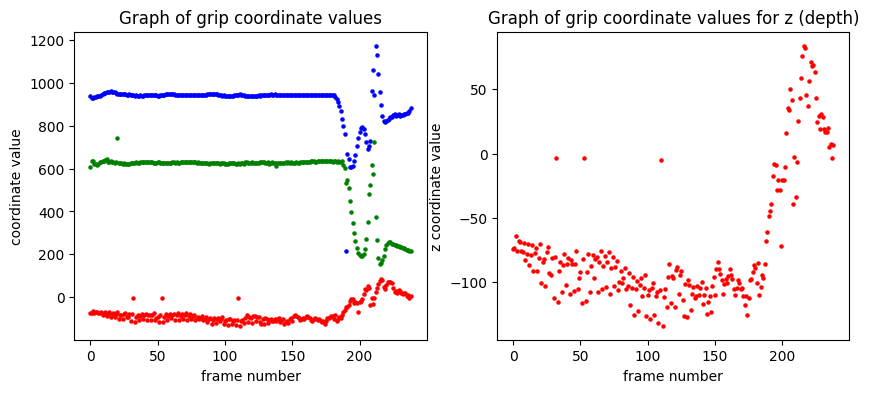

In [35]:
grip_coordinates = []
for i in range(len(poses)):
    pos = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()
    pos = align_3d_skeleton(pos, frame_2d_keypoints, print_difference = False)

    average_wrist_z = pos[[13, 16], 2].mean()
    grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z])
    grip_coordinates.append(grip)

grip_coordinates = np.array(grip_coordinates)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 0], marker='o', color='blue', label='grip x', s = 5)
ax1.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 1], marker='o', color='green', label='grip y', s = 5)
ax1.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 2], marker='o', color='red', label='grip z', s = 5)

ax2.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 2], marker='o', color='red', label='grip z', s = 5)
# Add title and axis labels
ax1.set_title("Graph of grip coordinate values")
ax1.set_xlabel('frame number')
ax1.set_ylabel('coordinate value')
ax2.set_title("Graph of grip coordinate values for z (depth)")
ax2.set_xlabel('frame number')
ax2.set_ylabel('z coordinate value')

plt.show()

Radius = 600
No real z solutions for i=211


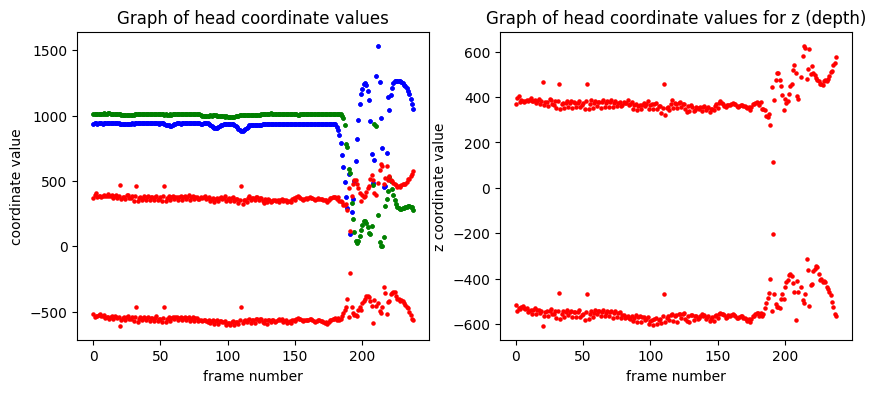

In [38]:
def sphere_z_values(x, y, center, radius):
    x0, y0, z0 = center
    r_squared = radius ** 2

    # Calculate the term inside the square root
    term = r_squared - (x - x0) ** 2 - (y - y0) ** 2

    # Check if the term is non-negative, as square root of a negative number is not real
    if term >= 0:
        sqrt_term = term ** 0.5
        z1 = z0 + sqrt_term
        z2 = z0 - sqrt_term
        return z1, z2
    else:
        return None

radius = 600 # pos.max()-pos.min()
print(f"Radius = {radius}")
grip_coordinates = []
possible_head_coordinates = []
for i in range(len(poses)):
    pos = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()
    pos = align_3d_skeleton(pos, frame_2d_keypoints, print_difference = False)

    average_wrist_z = pos[[13, 16], 2].mean()
    grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z])
    grip_coordinates.append(grip)

    z_values = sphere_z_values(*frame_club_2d_keypoints[1], grip, radius)
    if z_values is not None:
        possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[0]]])
        possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[1]]])
    else:
        print(f"No real z solutions for i={i}")

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][0] for x in possible_head_coordinates], marker='o', color='blue', label='head x', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][1] for x in possible_head_coordinates], marker='o', color='green', label='head y', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][2] for x in possible_head_coordinates], marker='o', color='red', label='head z', s = 5)

ax2.scatter([x[0] for x in possible_head_coordinates], [x[1][2] for x in possible_head_coordinates], marker='o', color='red', label='head z', s = 5)
# Add title and axis labels
ax1.set_title("Graph of head coordinate values")
ax1.set_xlabel('frame number')
ax1.set_ylabel('coordinate value')
ax2.set_title("Graph of head coordinate values for z (depth)")
ax2.set_xlabel('frame number')
ax2.set_ylabel('z coordinate value')

plt.show()

Radius = 600
No real z solutions for i=211


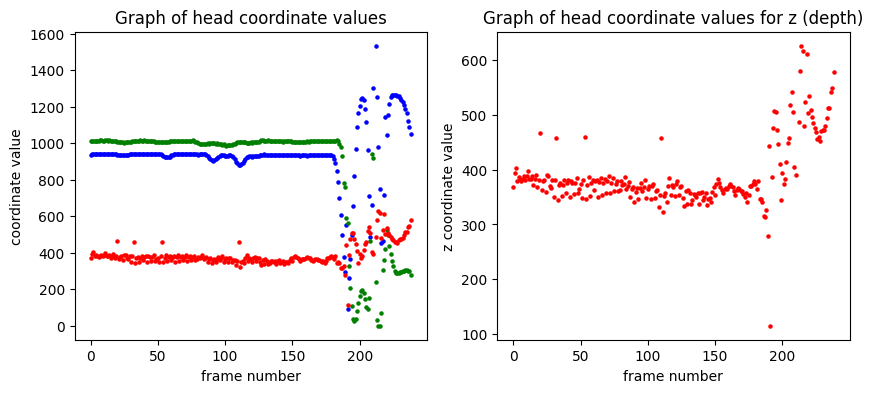

In [39]:
radius = 600 # pos.max()-pos.min()
print(f"Radius = {radius}")
grip_coordinates = []
possible_head_coordinates = []
for i in range(len(poses)):
    pos = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()
    pos = align_3d_skeleton(pos, frame_2d_keypoints, print_difference = False)

    average_wrist_z = pos[[13, 16], 2].mean()
    grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z])
    grip_coordinates.append(grip)

    z_values = sphere_z_values(*frame_club_2d_keypoints[1], grip, radius)
    if z_values is not None:
        possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[0]]])
        # possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[1]]]
    else:
        print(f"No real z solutions for i={i}")

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][0] for x in possible_head_coordinates], marker='o', color='blue', label='head x', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][1] for x in possible_head_coordinates], marker='o', color='green', label='head y', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][2] for x in possible_head_coordinates], marker='o', color='red', label='head z', s = 5)

ax2.scatter([x[0] for x in possible_head_coordinates], [x[1][2] for x in possible_head_coordinates], marker='o', color='red', label='head z', s = 5)
# Add title and axis labels
ax1.set_title("Graph of head coordinate values")
ax1.set_xlabel('frame number')
ax1.set_ylabel('coordinate value')
ax2.set_title("Graph of head coordinate values for z (depth)")
ax2.set_xlabel('frame number')
ax2.set_ylabel('z coordinate value')

plt.show()

In [46]:
def generate_possible_coordinates(radius, poses, keypoints, club_keypoints_2d):
    # radius = 600 # pos.max()-pos.min()
    # print(f"Radius = {radius}")
    grip_coordinates = []
    possible_head_coordinates = []
    for i in range(len(poses)):
        pos = poses[i].copy()
        frame_2d_keypoints = keypoints[i].copy()
        frame_club_2d_keypoints = club_keypoints_2d[i].copy()
        
        average_wrist_z = pos[[13, 16], 2].mean()
        grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z])
        z_values = sphere_z_values(*frame_club_2d_keypoints[1], grip, radius)

        if z_values is not None:
            possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[0]]])
            # possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[1]]])
        else:
            print(f"No real z solutions for radius={radius}, i={i}")
    
    return possible_head_coordinates

adjusted_poses = []
for i in range(len(poses)):
    pos = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()

    pos = align_3d_skeleton(pos, frame_2d_keypoints, print_difference = False)
    adjusted_poses.append(pos)
adjusted_poses = np.array(adjusted_poses)

No real z solutions for radius=700, i=211
No real z solutions for radius=600, i=211
No real z solutions for radius=500, i=191
No real z solutions for radius=500, i=211
No real z solutions for radius=400, i=0
No real z solutions for radius=400, i=138
No real z solutions for radius=400, i=185
No real z solutions for radius=400, i=186
No real z solutions for radius=400, i=187
No real z solutions for radius=400, i=188
No real z solutions for radius=400, i=189
No real z solutions for radius=400, i=191
No real z solutions for radius=400, i=192
No real z solutions for radius=400, i=198
No real z solutions for radius=400, i=199
No real z solutions for radius=400, i=200
No real z solutions for radius=400, i=201
No real z solutions for radius=400, i=202
No real z solutions for radius=400, i=203
No real z solutions for radius=400, i=204
No real z solutions for radius=400, i=205
No real z solutions for radius=400, i=209
No real z solutions for radius=400, i=210
No real z solutions for radius=400, 

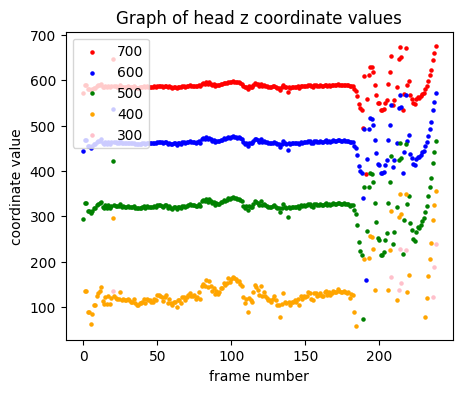

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

radiuses = [700, 600, 500, 400, 300]
colours = ['red', 'blue', 'green', 'orange', 'pink']
for radius, colour in zip(radiuses, colours):
    possible_head_coordinates = generate_possible_coordinates(radius, poses, keypoints, club_keypoints_2d)
    ax.scatter([x[0] for x in possible_head_coordinates], [x[1][2] for x in possible_head_coordinates], marker='o', color=colour, label=f'{radius}', s = 5)

# Add title and axis labels
ax.set_title("Graph of head z coordinate values")
ax.set_xlabel('frame number')
ax.set_ylabel('coordinate value')

plt.legend(loc="upper left")
plt.show()

In [20]:
list(frame_club_2d_keypoints[1]) + [z_values[0]]

[943, 1014, 383.11695799051427]

In [10]:


grip_coordinates = np.array(grip_coordinates)

array([938.        , 607.        , -74.50476074])

1202.988

In [6]:



# Example: center point (2, 2, 2), radius 3, x=4, y=3
center_point = (2, 2, 2)
radius = 3
x = 4
y = 3


if z_values:
    z1, z2 = z_values
    print("Z solutions:", z1, z2)

Z solutions: 4.0 0.0


In [ ]:
import math
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import subprocess as sp

def get_resolution(filename):
    """Returns height, width of video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=width,height', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            w, h = line.decode().strip().split(',')
            return int(w), int(h)
            
def get_fps(filename):
    """Returns the fps of the video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=r_frame_rate', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            a, b = line.decode().strip().split('/')
            return int(a) / int(b)

def read_video(filename, skip=0, limit=-1):
    """This function reads a video file and yields each frame as a numpy array in RGB format"""
    w, h = get_resolution(filename)
    
    command = ['ffmpeg',
            '-i', filename,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vsync', '0',
            '-vcodec', 'rawvideo', '-']
    
    i = 0
    with sp.Popen(command, stdout = sp.PIPE, bufsize=-1) as pipe:
        while True:
            data = pipe.stdout.read(w*h*3)
            if not data:
                break
            i += 1
            if i > limit and limit != -1:
                continue
            if i > skip:
                yield np.frombuffer(data, dtype='uint8').reshape((h, w, 3))


# Load video using ffmpeg
for f in read_video('videos/output.mp4', skip = i):
    frame = f
    break

<Figure size 1440x1080 with 0 Axes>

<Figure size 2700x1350 with 0 Axes>

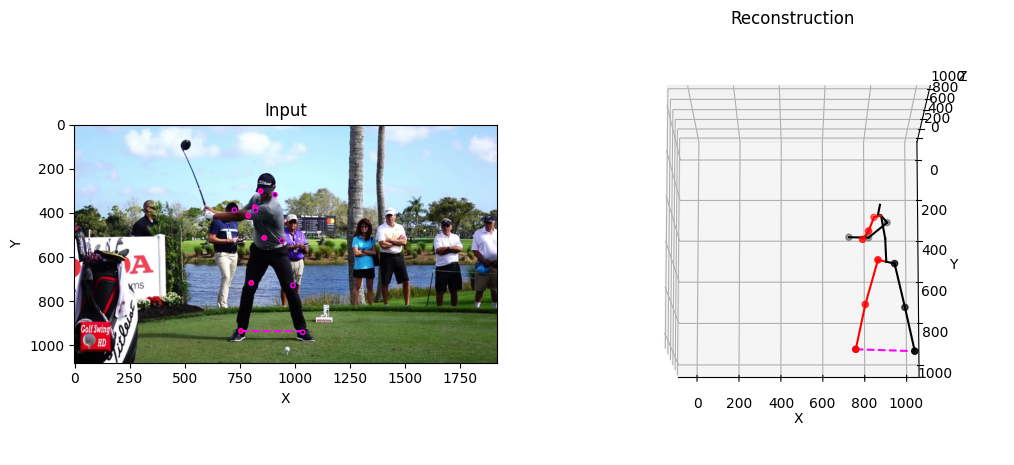

In [ ]:
# !pip install ipympl
# from google.colab import output
# output.enable_custom_widget_manager()
# %matplotlib widget

#use %matplotlib inline for non interactive
%matplotlib inline

size = 6

plt.clf() 
fig = plt.figure(figsize=(2*size, size)) # 6x6
ax_in = fig.add_subplot(1, 2, 1)
# ax_in.get_xaxis().set_visible(False)
# ax_in.get_yaxis().set_visible(False)

ax_in.set_xlabel('X')
ax_in.set_ylabel('Y')

# ax_in.set_axis_off()
ax_in.set_title('Input')
ax_3d = []
ax = fig.add_subplot(1, 2, 2, projection='3d')

max_value = pos.max()
min_value = pos.min()
ax.set_xlim3d([min_value, max_value])
ax.set_zlim3d([min_value, max_value])
ax.set_ylim3d([min_value, max_value])
try:
    ax.set_aspect('equal')
except NotImplementedError:
    ax.set_aspect('auto')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.dist = 7.5
ax.set_title("Reconstruction") #, pad=35


# Update 2D poses
joints_right_2d = keypoints_symmetry[1]
colors_2d = np.full(keypoints.shape[1], 'black')
colors_2d[joints_right_2d] = 'red'
image = ax_in.imshow(frame, aspect='equal')


for j, j_parent in enumerate(skeleton_parents):
    if j_parent == -1:
        continue
        
    col = 'red' if j in joints_right else 'black'
    
    ax.plot([pos[j, 0], pos[j_parent, 0]],
                  [pos[j, 1], pos[j_parent, 1]],
                  [pos[j, 2], pos[j_parent, 2]], zdir='z', c=col)


# red_foot_3d, red_shoulder_3d = pos[[3, 14]]
# ax.plot(*np.array([red_foot_3d, red_shoulder_3d]).T, linestyle = 'dashed', color = 'fuchsia')
# ax_in.plot(*np.array([red_foot_3d[:2], red_shoulder_3d[:2]]).T, linestyle = 'dashed', color = 'fuchsia')

#3d [3, 6], 2d [16, 15]
ax.plot(*pos[[3, 6]].T, linestyle = 'dashed', color = 'fuchsia')
ax_in.plot(*frame_2d_keypoints[[16, 15]].T, linestyle = 'dashed', color = 'fuchsia')


#plot points which show on both
ax.scatter(*pos[valid_pairings[:, 0]].T, color = ['red', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'red', 'red'])
# ax_in.scatter(*frame_2d_keypoints[valid_pairings[:, 1]].T, 10, color=colors_2d[valid_pairings[:, 1]], edgecolors='white', zorder=10)
ax_in.scatter(*pos[valid_pairings[:, 0]][:, :2].T, 10, color=colors_2d[valid_pairings[:, 1]], edgecolors='fuchsia', zorder=10)


# #Plotting club:
# average_wrist_z = pos[[13, 16], 2].mean()
# grip = np.array(list(club_2d_keypoints_frame[0]) + [average_wrist_z])
# head = np.array(list(club_2d_keypoints_frame[1]) + [average_wrist_z])
# ax_in.scatter(*grip[:2], 10, color='green', edgecolors='white', zorder=10)
# ax_in.scatter(*head[:2], 10, color='green', edgecolors='white', zorder=10)
# ax_in.plot(*np.array([grip, head]).T, linestyle = 'dashed', color = 'green')
# ax.scatter(*grip, color = 'green')
# ax.scatter(*head, color = 'deeppink')
# ax.plot(*np.array([list(grip), list(head)]).T, linestyle = 'dashed', color = 'green')

ax.view_init(elev=80., azim=90) # Note Y axis increases as it goes down on image so need to rotate 3d plot
ax.invert_xaxis()
plt.show()

In [ ]:
red_foot_3d, black_foot_3d = pos[[3, 6]]
red_foot_2d, black_foot_2d = frame_2d_keypoints[[16, 15]]
angle_3d = calculate_angle(red_foot_3d[:2], black_foot_3d[:2])
angle_2d = calculate_angle(red_foot_2d, black_foot_2d)
angle_diff = angle_2d - angle_3d
print(f"angle_3d: {angle_3d}, angle_2d: {angle_2d}, {angle_diff}")

angle_3d: 8.408169225074795, angle_2d: 8.602817213071269, 0.19464798799647376


In [ ]:
red_foot_3d, black_foot_3d = pos[[3, 6], :2]
red_foot_2d, black_foot_2d = frame_2d_keypoints[[16, 15]]
print(red_foot_2d, black_foot_2d)
print(red_foot_3d, black_foot_3d)

[758.7394 926.5137] [1032.3995  932.2719]
[758.7394 926.5137] [1032.1985   938.47656]


In [ ]:
red_foot_3d[:2], black_foot_3d[:2]

Angle between the two points: 8.408169225074795 degrees
